Welcome to this notebook! If you're new to Python, don't worry, this notebook is designed to help you get familiar with some concepts of Machine Learning. You can simply run the script to see how it works. On the other hand, if you're familiar with Python, feel free to change the parameters to better understand how it works.

Whether you're a beginner or an experienced user, we hope you find this notebook informative and helpful.

# Setup

## - Working locally 
If you're running this notebook locally, you might need to create a proper conda environment using the file "environment.yml":
- conda env create -f environment.yml (the first line of the yml file sets the new environment's name.)
- conda activate myenv (the environment's name)
- conda install -c anaconda ipykernel
- python -m ipykernl install --user --name=myenv

Using the above command, you will have the appropriate conda environment in your Jupyter notebook.
![kernel](adding_conda_kernel.jpeg)

Change the kernel to be your new environement: 'mooc_ntbk' if you kept the default name.
Please consider running the cell below to handle some version conflicts.

In [1]:
#--------------------------------------# 
# Fix python path of working locally   #
#--------------------------------------#
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
path = './data/'

## - Running the tutorial via free cloud platforms


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/obs-env.ipynb)

First, let's install and import some useful libraries/modules. 

In [197]:
#--------------------------#
# Install some libraries   #
#--------------------------#
!pip install --quiet openturns darts matplotlib==3.6.3

In [2]:
#-----------------------------# 
# Import external libraries   #
#-----------------------------#
import os
import sys

import numpy as np 
import pandas as pd

import openturns as ot
from openturns.viewer import View

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

from darts.utils.statistics import check_seasonality, plot_acf, TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, ExponentialSmoothing, Prophet, RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [12, 7]

import datetime, time

import logging
logging.disable(logging.CRITICAL)
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

/Users/masg/opt/anaconda3/envs/mooc-ntbk/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#----------------------# 
# Download data        #
#----------------------#
!wget https://github.com/syam5g/mooc-machine-learning-weather-climate/tree/main/tier_3/observations/data.zip

--2023-03-07 12:01:39--  https://github.com/syam5g/mooc-machine-learning-weather-climate/tree/main/tier_3/observations/data.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/syam5g/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/data.zip [following]
--2023-03-07 12:01:39--  https://github.com/syam5g/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'data.zip.1'

data.zip.1              [ <=>                ] 135.53K  --.-KB/s    in 0.05s   

2023-03-07 12:01:39 (2.61 MB/s) - 'data.zip.1' saved [138778]



In [3]:
# Unzip the data
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/dis_obs_clim.csv   
  inflating: __MACOSX/data/._dis_obs_clim.csv  
  inflating: data/y_train.npy        
  inflating: __MACOSX/data/._y_train.npy  
  inflating: data/y_test.npy         
  inflating: __MACOSX/data/._y_test.npy  
  inflating: data/x_test.npy         
  inflating: __MACOSX/data/._x_test.npy  
  inflating: data/x_train.npy        
  inflating: __MACOSX/data/._x_train.npy  
  inflating: data/hydrograph.txt     
  inflating: __MACOSX/data/._hydrograph.txt  


# 1) Generating perturbations to account for uncertainties in discharge observations

All observations have some degree of uncertainty associated with them, whether it be due to measurement errors, variability in the system being observed, or other factors. By quantifying this uncertainty we can account for the limitations of the data and to appropriately interpret the results of our analysis. It also helps to identify areas where further data collection or analysis may be needed to reduce uncertainty and improve the reliability of our conclusions.

## a. Discharge observation data
Discharge observations during a flood event can be obtained through various methods including:

- Stream gauges: Physical instruments installed along rivers or streams that measure the flow of water.

- Remote sensing: Use of satellite imagery and other aerial technologies to estimate discharge from above.

- Numerical models: Predictive simulations that use historical data and real-time weather data to estimate discharge.

- Field measurements: Direct measurement of water flow velocity and cross-sectional area to estimate discharge.

In [4]:
path = './data/'

Text(0.5, 1.0, 'Hydrograph in the upstream station \n of a catchment during a flood event')

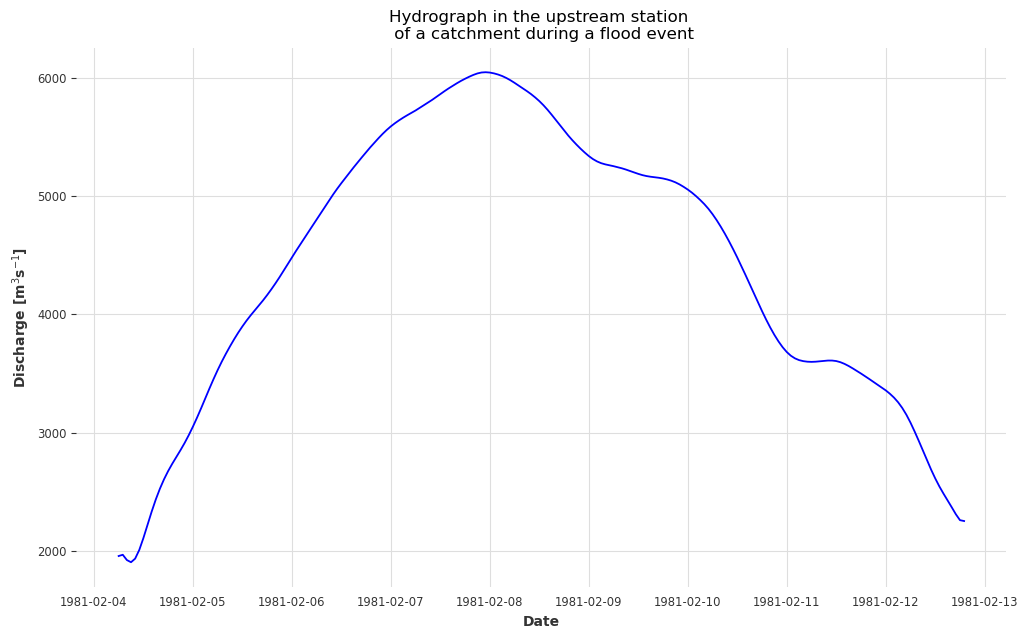

In [133]:
#--------------------------------#
# Read data                      #
#--------------------------------#
# Read a hydrograph of a flood event of ~8 days. The data is hourly
filename = 'hydrograph.txt'
n_skipLine = 1 
qt = ot.Sample.ImportFromTextFile(os.path.join(path, filename), ' ', n_skipLine)
t = qt.getMarginal(0) #time in sec, ref date is 04/02/1981 at 6:00am
q = qt.getMarginal(1)

tdate = pd.date_range(start='2/4/1981 6H', periods=len(qt), freq='H')

plt.plot(tdate, q, color='blue')
plt.xlabel("Date")
plt.ylabel("Discharge [m$^3$s$^{-1}$]")
plt.title('Hydrograph in the upstream station \n of a catchment during a flood event')

Discharge observations are uncertain due to several factors, including:

- Measurement error: Discharge measurements can be affected by measurement error, such as the accuracy of the measurement device or the presence of debris in the river that can block the device. This can result in readings that are higher or lower than the actual discharge.

- Channel changes: Changes to the river channel, such as sediment deposition or erosion, can alter the relationship between stage (water level) and discharge. This can result in discharge observations that are not accurate or reliable.

- Inadequate data: In some cases, discharge observations may not be available for all periods of interest, or the data may be sparse or of low quality. This can result in significant uncertainty in the discharge observations.

- Interpolation and extrapolation: In some cases, discharge observations may need to be interpolated or extrapolated to estimate discharge at ungauged locations or over longer periods of time. This can result in additional uncertainty in the discharge observations.

These are just a few examples of why discharge observations can be uncertain. It is important to understand the sources of uncertainty in discharge observations and to use appropriate methods to account for this uncertainty when analyzing and using discharge data. In our case, we will consider ensemble methods by perturbing the hydrograph to account for uncertainties.

## b. Discharge perturbations

To create realistic perturbations, we use the covariance to model the relationship between discharge at different timesteps.

The covariance model of a time series is a statistical model that describes the dependence structure of the series over time. In particular, the covariance model specifies the relationship between the mean and variance of the series as well as the correlation between observations at different points in time. The covariance between two observations at times $t$ and $s$ is defined as:

$Cov(X_t, X_s) = E[(X_t - μ_t)(X_s - μ_s)]$

where $X_t$ and $X_s$ are the values of the time series at times $t$ and $s$, $μ_t$ and $μ_s$ are the means of the time series at times $t$ and $s$, and $E$ is the expected value operator.

The covariance model of a time series assumes that the time series is stationary, meaning that its statistical properties do not change over time. Under this assumption, the covariance between two observations only depends on the time lag between them, and not on the specific time points at which they occur. In other words, the covariance between $X_t$ and $X_s$ only depends on the time difference $|t-s|$.

E20230308 17:11:07.331451 112918 trust_region_minimizer.cc:95] Terminating: Number of consecutive invalid steps more than Solver::Options::max_num_consecutive_invalid_steps: 5
WRN - Switch to finite difference to compute the gradient at point=[818248,-25.8623,-0.000135101]
WRN - TNC went to an abnormal point x=[nan,nan,nan] y=[] msg=TNC got a nan input value


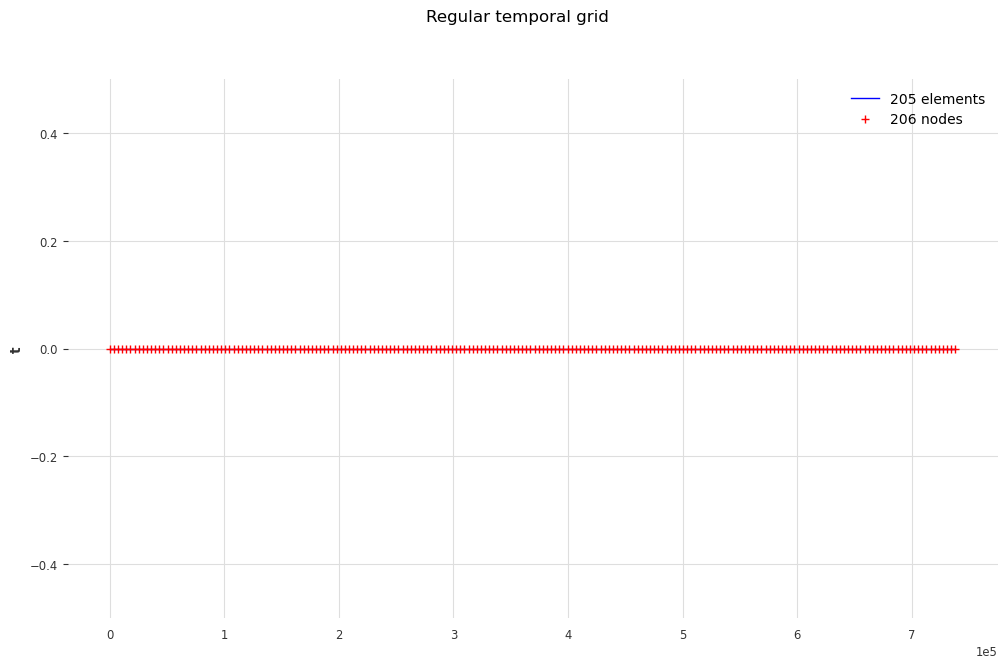

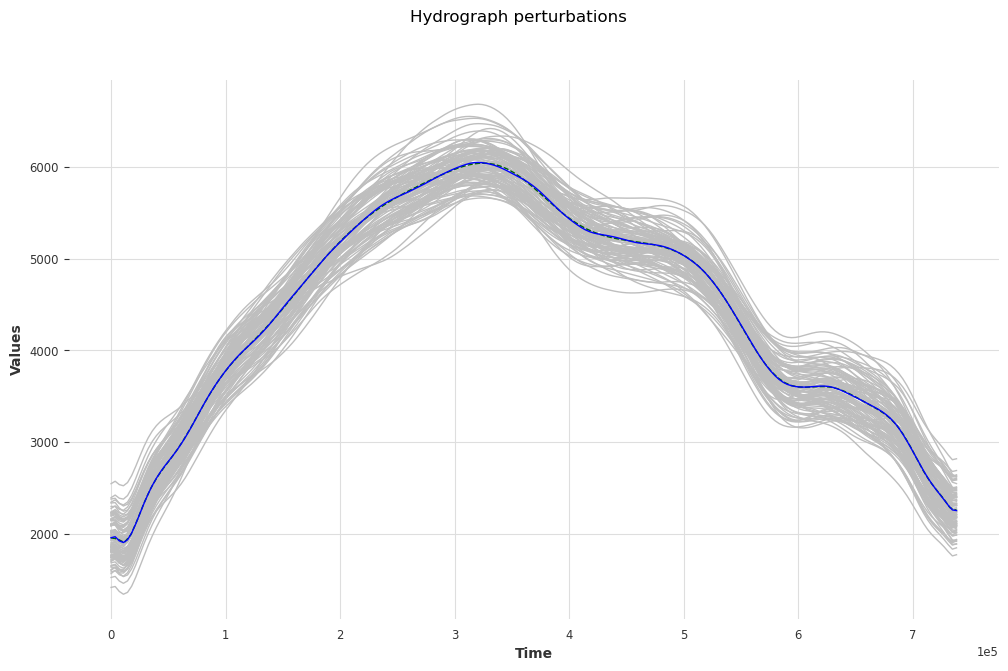

In [145]:
#-----------------------------------------#
# Define the temporal grid accoring to    # 
# the timesteps defined in the hydrograph #
#-----------------------------------------#
myTimeGrid = ot.RegularGrid(np.min(t), t[1, 0] - t[0, 0], t.getSize())
graph = myTimeGrid.draw()
graph.setTitle("Regular temporal grid")
view = ot.viewer.View(graph)

#----------------------------------------------------------------#
# Identify the time series with a Polynomial Chaos Expansion     #
#----------------------------------------------------------------#
max_poly_degree = 25
ot.ResourceMap.SetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree", max_poly_degree)
algo = ot.FunctionalChaosAlgorithm(t, q)
algo.run()
trend = algo.getResult().getMetaModel()

#-------------------------------------------------------#
# Calibrate the covariance model using expert knowledge #
#-------------------------------------------------------# 
# The Matern covariance function is commonly used as a kernel function in a Gaussian Process.
amplitude = [200] # We assume that, on average, the difference of discharge between two observations is 200 m3/s
scale = [86400] # We assume that the correlation length is of 1 day
nu = 5/2
covarianceModel = ot.MaternModel(scale, amplitude, nu)

#------------------------------------------------------------------#
# Create a Gaussian process to get realizations past the last time #
#------------------------------------------------------------------#
process = ot.GaussianProcess(ot.TrendTransform(trend, mesh), covarianceModel, mesh)
nb = 100 # number of desired perturbations
sample = process.getSample(nb)
g = sample.drawMarginal(0)
g.setColors(["gray"]) # Perturbations are plotted in solid gray lines
c = trend.draw(mesh.getVertices()[0], mesh.getVertices()[-1]).getDrawable(0) 
c.setLineStyle("dashed") 
c.setColor("darkgreen") # Polynomial model is plotted in dashed green line
g.add(c)
g.add(ot.Curve(t,q)) # Observed discharge in blue
g.setTitle("Hydrograph perturbations")
ot.Show(g)

- Perturbations were generated using a Gaussian process model. 
- To construct a Gaussian process model, we need to specify the mean and and the covariance of the process.
- Polynomial Chaos expansion model was used to fit the observed discharge. Its mean/trend was considered to be the mean of the Gaussian process.
- The covariance of the Gaussian process, in our case, was constructed based on the hydrologist judgement. 

###  <div class="alert-danger"> Q1) How does the hydrograph perturbation change according to: Amplitude? Scale? Maximum polynomial degree? </div>  

# 2) Predictive model of the water level at a station given the Strickler coefficient at this station and the discharge at the upstream area

Now, let's build a surrogate model that predicts the water level timeseries in a station in the middle of the catchment given the Strickler coefficient in this station and the discharge in the upstream station at a given timestep. The Strickler coefficient reflects the roughness of the bottom of the river at a given location. 

The size of the input training data is 1,000 members. They are derived from a perturbation procedure similar to the one described above. The input data contain the upstream discharge (x_train[:,0]) and the Strickler coefficient (x_train[:,1]). The different outputs of the hydrodynamic model are grouped in the output training data and describe a timeseries (52 timesteps) of the water height at a station located in the middle of the catchment.

The size of the test file is 500 members. The test file and the training file were constructed independently. 

In [18]:
#------------------#
# Upload data      #
#-----------------# 
### Training data
x_train = np.load(os.path.join(path, 'x_train.npy'))
y_train = np.load(os.path.join(path, 'y_train.npy'))

### Test data
x_test = np.load(os.path.join(path, 'x_test.npy'))
y_test = np.load(os.path.join(path, 'y_test.npy'))

print("The size of the training sample is: {:d}".format(x_train.shape[0]))
print("The size of the test sample is: {:d}".format(x_test.shape[0]))
print("Number of features is: {:d}".format(x_train.shape[1]))

The size of the training sample is: 1000
The size of the test sample is: 500
Number of features is: 2


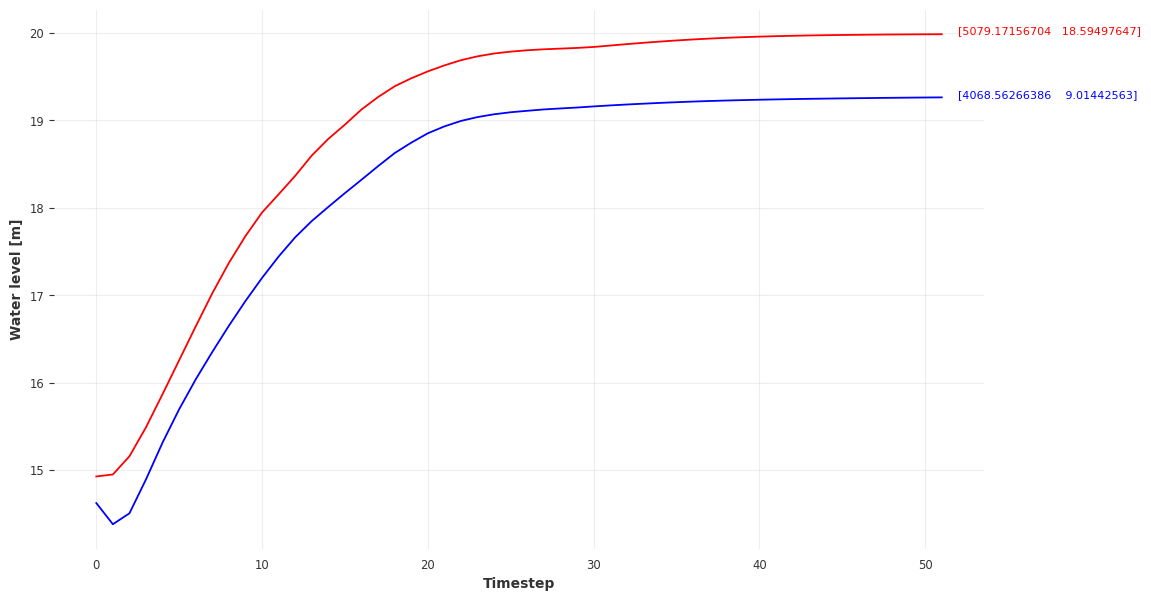

In [19]:
#------------------#
# Visualise data   #
#------------------# 
### Before diving into constructing the surrogate model, one necessary step is: Data visualisation

# plot the max and min of the simulation according to the last timestep
simu_max = np.argmax((y_train[:][-1]))
plt.plot(y_train[simu_max], c='red')
plt.text(y_train.shape[1], y_train[simu_max][-1], x_train[simu_max], fontsize=8, c='red') 

simu_min = np.argmin((y_train[:][-1]))
plt.plot(y_train[simu_min], c='blue')
plt.text(y_train.shape[1], y_train[simu_min][-1], x_train[simu_min], fontsize=8, c='blue') 

plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Water level [m]')
plt.grid(alpha=0.5)
plt.show()

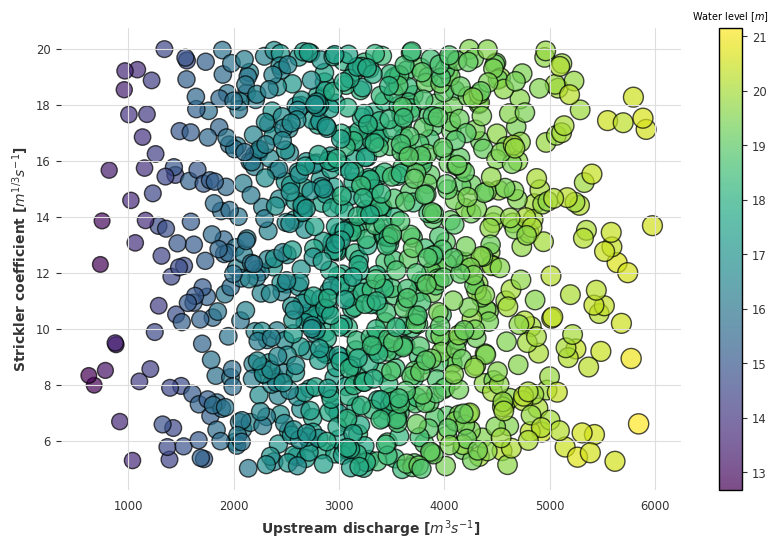

In [20]:
# plot changes in the water level in the last timestep accriding to the discharge and the Strickler coefficient
x = x_train[:,0]
y = x_train[:,1]

timestep = -1 # last time step 
z = y_train[:,timestep]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = z*10,
           c=z)
plt.xlabel('Upstream discharge [$m^3s^{-1}$]')
plt.ylabel('Strickler coefficient [$m^{1/3}s^{-1}$]')

clb = plt.colorbar()
clb.ax.set_title('Water level [$m$]', fontsize=7)
plt.show()

Let's build a Decision Tree regressor model to mimic the behaviour of the hydrodynamic model to speed up this latter.

A Decision Tree Regressor is a supervised learning algorithm that is used for regression tasks. The algorithm builds a tree-like model of decisions and their possible consequences, where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a prediction for the target variable.

The Decision Tree algorithm works by recursively splitting the data into subsets based on the values of a selected attribute. The attribute with the highest predictive power is selected as the root node of the tree, and the data is split based on its values. The process is repeated for each subset until the leaf nodes are reached, where the prediction is made for the target variable.

The goal of the Decision Tree regressor is to minimize the variance of the target variable within each leaf node while maximizing the difference in the means between different leaf nodes. This is achieved by selecting the optimal split point for each node based on the variance reduction criterion, such as the mean squared error (MSE) or mean absolute error (MAE).

For more information, please check: https://scikit-learn.org/stable/modules/tree.html#tree

In [21]:
#------------------------------#
# Train a DecisionTree model   #
#------------------------------# 
### Constructing a surrogate model
rf = DecisionTreeRegressor()
training_start_time = time.process_time() #CPU time
rf_model = rf.fit(x_train, y_train)
print(f'CPU time for training is: {time.process_time() - training_start_time}')
test_start_time = time.process_time()
y_pred = rf_model.predict(x_test)
print(f'CPU time for test is: {time.process_time() - test_start_time}')
# If you want to measure wall clock time instead, use time.time()

### How good are the predictions?
q2_score = r2_score(y_pred, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("The R2 score on test set: {:.4f}".format(q2_score))
print("The root mean squared error (RMSE) on test set: {:.4f} [m]".format(rmse))

CPU time for training is: 0.02032599999999718
CPU time for test is: 0.0005559999999960041
The R2 score on test set: 0.8473
The root mean squared error (RMSE) on test set: 0.3035 [m]


In [23]:
#------------------------------------#
# Visualise the DecisionTree model   #
#------------------------------------# 
plot = False # Visualise the decision tree as plot; it takes time and the generated plot is not readable 
if plot:
    fig = plt.figure(figsize=(25,20)) 
    _ = tree.plot_tree(rf, filled=True)
text_representation = tree.export_text(rf) # Visualise the decision tree as text 
print(text_representation)

|--- feature_0 <= 2833.19
|   |--- feature_0 <= 1913.17
|   |   |--- feature_0 <= 1226.58
|   |   |   |--- feature_0 <= 900.83
|   |   |   |   |--- feature_0 <= 766.31
|   |   |   |   |   |--- feature_1 <= 13.08
|   |   |   |   |   |   |--- feature_0 <= 650.13
|   |   |   |   |   |   |   |--- value: [14.67, 14.38, 14.32, 14.42, 14.51, 14.53, 14.50, 14.44, 14.35, 14.25, 14.14, 14.02, 13.90, 13.77, 13.64, 13.51, 13.38, 13.24, 13.11, 12.99, 12.90, 12.83, 12.78, 12.75, 12.73, 12.72, 12.71, 12.71, 12.71, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70, 12.70]
|   |   |   |   |   |   |--- feature_0 >  650.13
|   |   |   |   |   |   |   |--- feature_0 <= 704.92
|   |   |   |   |   |   |   |   |--- value: [14.70, 14.28, 14.14, 14.21, 14.29, 14.30, 14.27, 14.20, 14.12, 14.02, 13.92, 13.81, 13.70, 13.59, 13.47, 13.35, 13.23, 13.11, 12.99, 12.89, 12.81, 12.76, 12.73, 12.71, 12.69, 12.69, 12.68

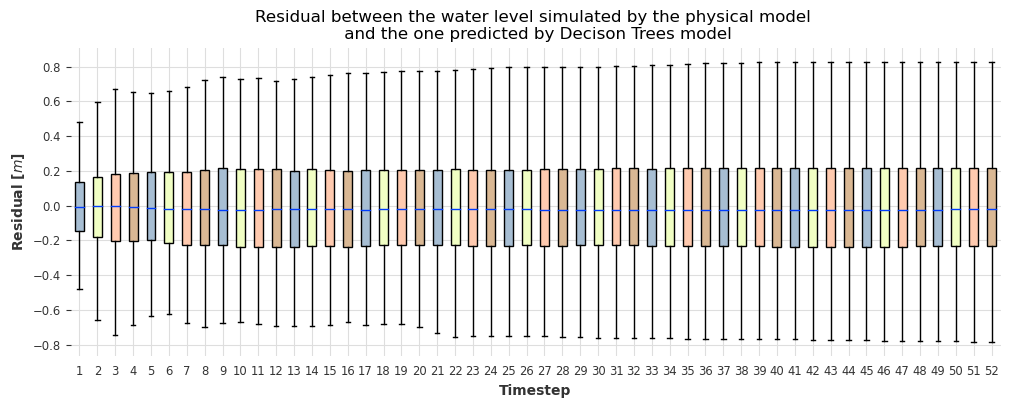

In [147]:
#--------------------#
# Plot the residual  #
#------------------––#
# Plot the difference between the water level in the test file and the one predicted by the ML model
residual = y_test - y_pred

# box plot
fig, ax = plt.subplots(figsize=(12, 4))
bplot = ax.boxplot(residual,
                     vert=True,  # vertical box alignment
                     patch_artist=True)  
colors = ['#a7bed3', '#f1ffc4', '#ffcaaf', '#dab894']*13
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Timestep')
plt.ylabel('Residual [$m$]')
plt.title('Residual between the water level simulated by the physical model \n and the one predicted by Decison Trees model')
plt.show()

### <div class="alert-danger">  Q2) Try to train another model on the dataset assuming that the RMSE should not exceed 30cm.  </div>  


# 3) Monthly flow climate data analysis 

In [5]:
#------------------------------------------------------------#
# Load the discharge historical data at a specific location  #
#------------------------------------------------------------#
df = pd.read_csv(os.path.join(path, 'dis_obs_clim.csv')) 
df['month'] = pd.to_datetime(df['month'])
df

,month,dis_observed
0,2000-01-01,49.141290
1,2000-02-01,63.602069
2,2000-03-01,69.980645
3,2000-04-01,28.339000
4,2000-05-01,28.950323
...,...,...
259,2021-08-01,16.082581
260,2021-09-01,13.500000
261,2021-10-01,23.997742
262,2021-11-01,30.696333


In [203]:
#------------------#
# Describe data    #
#------------------#
df.describe()

,dis_observed
count,238.000000
mean,36.476164
std,22.756222
min,11.276897
25%,19.501917
50%,27.838613
75%,49.193226
max,116.681786


<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

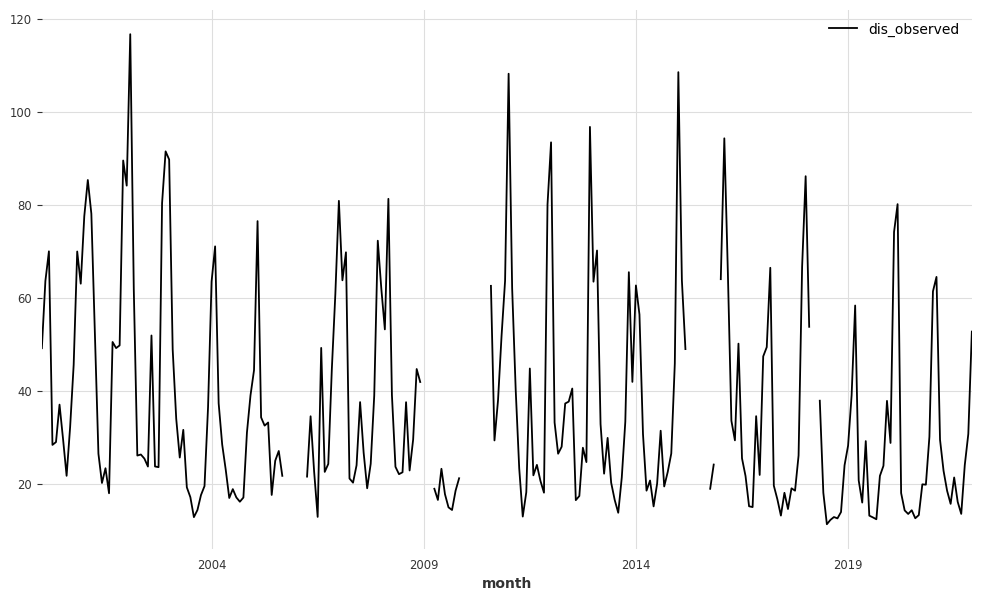

In [268]:
#------------#
# plot data  #
#------------#
plt.figure(100, figsize=(10,5))
df.plot(x='month', y='dis_observed', color = "black")

Handling missing values highly depends on the nature of the data, the size and location of the gaps, and the intended use of the data. In general, the main common strategies are: 
- Removing rows with missing values.
- Mark and learn missing values.
- Mask and learn without missing values.

Try each approach on your sequence prediction problem and double down on what appears to work best.
Here are some commonly used methods to fill gaps in a time series:

- Forward fill (or backward fill): This method fills the gap with the last (or first) observed value. This method is suitable when the missing values occur in sequences or when the data has a slowly changing trend.

- Linear interpolation: This method fills the gap with a straight line between the last observed value before the gap and the first observed value after the gap. This method is suitable when the data has a linear trend.

- Seasonal interpolation: This method fills the gap with a value that corresponds to the same season or time of day as the missing value. This method is suitable when the data has a seasonal pattern.

- Mean or median imputation: This method fills the gap with the mean or median of the observed values. This method is suitable when the data has a normal distribution.

- Regression imputation: This method uses regression models to predict the missing values based on the relationship between the time series and other relevant variables. This method is suitable when the data has complex patterns or when the gaps are large.

## a. Gap filling 
### a.1) Using Inverse Principal Component Analysis

Given a time series $X$ of length $n$, with $m$ missing values, IPCA aims to fill in the missing values by decomposing $X$ into its principal components and filling in the missing values in the principal component space. Let $X'$ be the filled-in time series, and let $P$ be the matrix of principal components. Then, IPCA can be expressed as:

$X' = P * diag(eigenvalues) * P^T$, 

where diag(eigenvalues) is a diagonal matrix of eigenvalues and $P^T$ is the transpose of $P$.

NB: $m$ should be small.

In [6]:
#-----------------------------------------#
# Compute the ratio of the missing values # 
#-----------------------------------------#
null_values = df['dis_observed'].isnull()
print('The ratio of missing values is: {:.2f} %'.format(round(sum(null_values)*100/len(df), 2)))

The ratio of missing values is: 9.85 %


In [270]:
#------------#
# Scale data #
#------------#
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(np.array(df['dis_observed']).reshape(-1,1))
df['dis_scaled'] = ts_scaled

<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

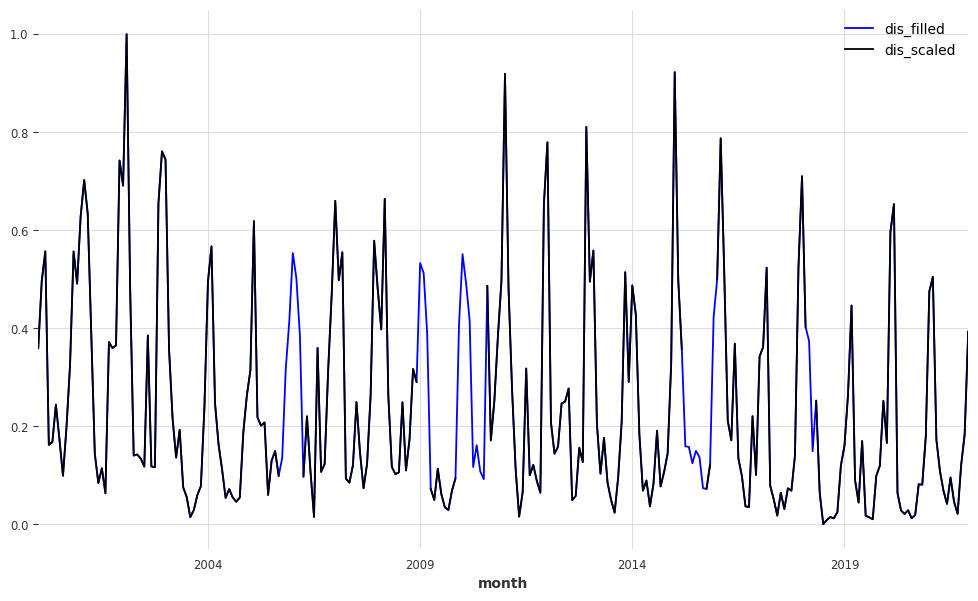

In [271]:
#-------------------------------------------#
# Impute missing values with PCA inverse    # 
#-------------------------------------------#
data_month = np.array(ts_scaled).reshape(-1, 12) # reshape data
data = np.where(np.isnan(data_month), np.ma.array(data_month, mask=np.isnan(data_month)).mean(axis=0), data_month) # imputation using the mean to get rid of NaN values so the PCA can be computed
pca = PCA(n_components=0.9)
data_filled = pca.inverse_transform(pca.fit_transform(data))
df['dis_pcai'] = list(data_filled.reshape(-1))
df['dis_filled'] = df['dis_scaled'].fillna(df['dis_pcai'])

### plot the PCA result
plt.figure(100, figsize=(10,5))
df.plot(x='month', y=['dis_filled', 'dis_scaled'], color = ["blue", "black"])

### a.2) Gap filling using Multivariate Imputation by Chained Equation

Multivariate Imputation by Chained Equation (MICE) first calculates the mean of every column where there is a missing value and uses the mean value as a placeholder. Then it runs a series of regression models (chained equations) to impute each missing value sequentially. Like in any regression model, MICE uses a feature matrix and target variable to train, and in this case, the target variable is the column with missing values. MICE predicts and updates missing values on target columns. Iteratively, MICE repeats this process several times by constantly changing the placeholder variables with the predictions from the previous iteration. In the end, it reaches a robust estimation.

In [273]:
#-------------------------------------------#
# Impute missing values with MICE           # 
#-------------------------------------------#
### Extract the month only (month_) to use it as a predictor for MICE
df['month_'] = [df['month'][x].month for x in range(len(df['month']))]

### Imputing with MICE
df_mice = df.filter(['month_','dis_scaled']).copy()

### Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

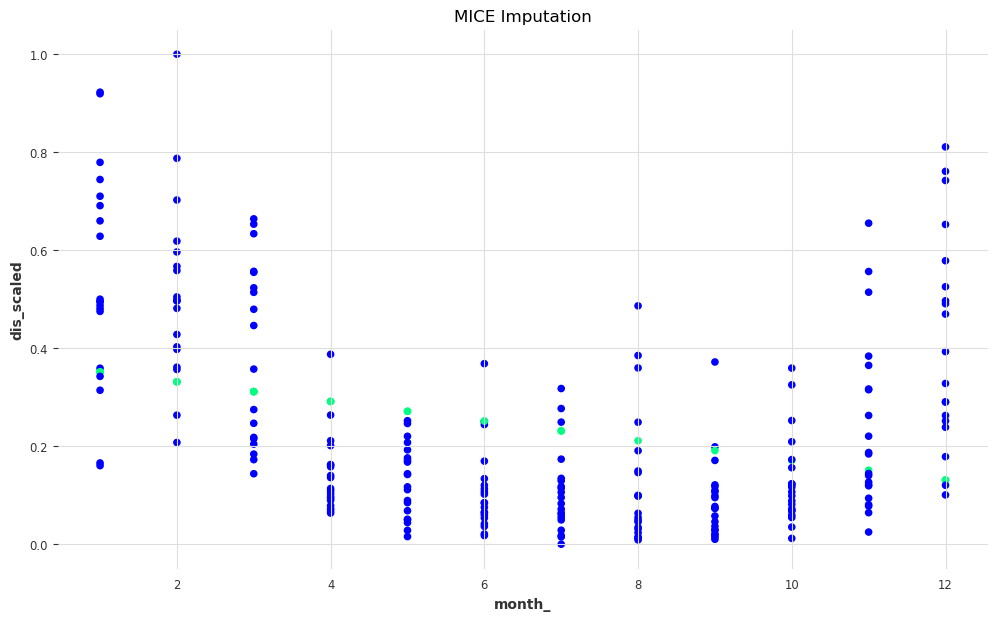

In [274]:
#-----------------#
#Plot MICE result # 
#-----------------#
fig = plt.Figure() 
fig = df_mice_imputed.plot(x='month_', y='dis_scaled', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

<AxesSubplot: xlabel='month'>

<Figure size 1000x500 with 0 Axes>

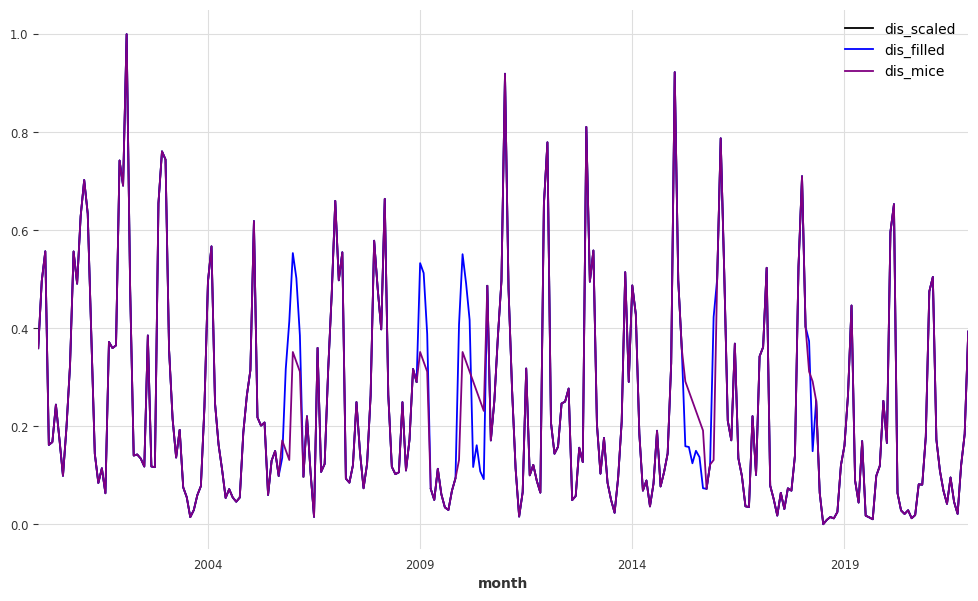

In [275]:
### Plot result as a time series
df['dis_mice'] = df_mice_imputed['dis_scaled']
plt.figure(100, figsize=(10,5))
df.plot(x='month', y=['dis_scaled', 'dis_filled', 'dis_mice'], color = ["black", "blue", "purple"])

In the following, we'll consider PCA inverse imputation.

## b. Time series forecasting

In [276]:
### analyze its seasonality
ts_scaled = TimeSeries.from_dataframe(df, 'month', 'dis_filled')
is_seasonal, periodicity = check_seasonality(ts_scaled, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


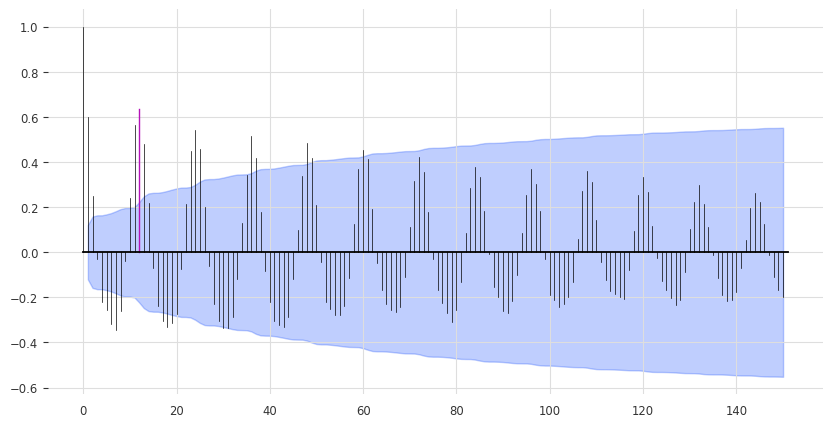

In [277]:
### plot its autocorrelation function
plot_acf(ts_scaled, periodicity, max_lag=150)

Neural Basis Expansion Analysis (NBEA) is a method for time series forecasting that combines neural networks with basis expansion techniques. The basic idea behind NBEA is to use a neural network to learn a mapping between the past values of a time series and its future values, while also using basis expansion techniques to capture non-linear relationships between the time series and its predictors.

NBEA works by first transforming the input time series into a basis-expanded representation, which captures non-linear relationships between the time series and its predictors. This basis-expanded representation is then used as input to a neural network, which learns a mapping between the past values of the time series and its future values. The output of the neural network is then transformed back into the original time series space.

The main advantage of NBEA is that it can capture complex non-linear relationships between the time series and its predictors, while also leveraging the power of neural networks for time series forecasting. NBEA has been shown to be effective for a wide range of time series forecasting tasks, including financial forecasting, environmental forecasting, and traffic forecasting.

In [34]:
#--------------------------------------------------#
# Forecast the last three years of the time series # 
# using NBEATS model                               #
#--------------------------------------------------#
### Split training vs test dataset
# Let's keep the last 36 months as test
ts_split = -36
train, test = ts_scaled[:ts_split], ts_scaled[ts_split:]

Let’s look at a first example. We’ll build an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so that our model will produce successive predictions for one year at a time, looking at the past two years.

In [36]:
### Define the model parameters
model = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=1
)

In [37]:
### Fit the model using the training data 
#--- for n_epochs=50, the training lasts ~2 minutes
nbeats_start_time = time.time()
model.fit(train, verbose=True)
print(f'Training duration time: {time.time() - nbeats_start_time}')

Epoch 49: 100%|███| 7/7 [00:01<00:00,  4.45it/s, loss=0.016, train_loss=0.00925]
Training duration time: 82.43937516212463


We can then get a forecast by calling predict(). 

Note that below, we are calling predict() with a horizon of 36, which is longer than the model internal output_chunk_length of 12. That’s not a problem here, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

MAPE = 'Mean Absolute Percentage Error'

Predicting DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 18.06it/s]
MAPE = 220.31%


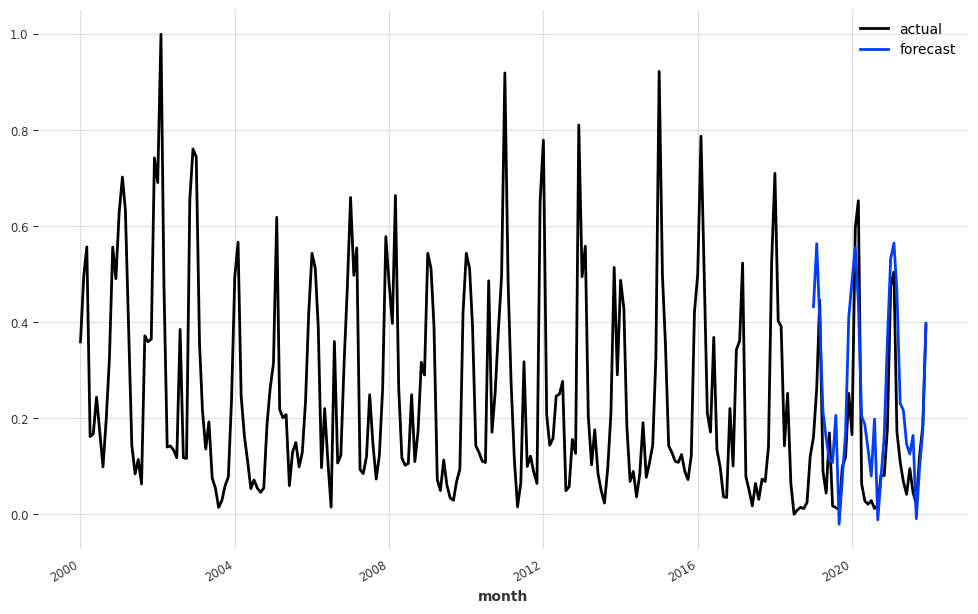

In [38]:
### Predict the test data 
pred = model.predict(n=36)
ts_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(ts_scaled, pred)))

Some options could be investigated to optimize the model:
- *Increase the number of epochs:* An epoch is one full pass through the training data, and increasing the number of epochs allows the model to see the training data more times and refine its weights accordingly. However, increasing the number of epochs beyond a certain point can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new data. Therefore, it's important to find the optimal number of epochs that balances between the underfitting and overfitting. This can be done by monitoring the validation loss while training the model and stopping the training when the validation loss starts to increase.

- *Increase the size of the model:* The NBEATSModel consists of several fully connected layers, and increasing the size of the model can help to increase its capacity and improve its performance. You can try adding more layers or increasing the number of units in each layer.

- *Adjust the learning rate:* The learning rate determines how much the weights of the model are updated during each iteration of training. If the learning rate is too high, the model may overshoot the optimal weights and fail to converge. If the learning rate is too low, the model may take a long time to converge. You can try adjusting the learning rate to find the optimal value.

- *Add regularization:* Regularization techniques such as L1 or L2 regularization, dropout, or early stopping can help to prevent overfitting and improve the generalization performance of the model. You can try adding one or more of these techniques to the model.

- *Use a different optimizer:* The optimizer is responsible for updating the weights of the model during training. Different optimizers have different strengths and weaknesses, and choosing the right optimizer can help to improve the performance of the model. You can try using a different optimizer, such as Adam or RMSprop, to see if it improves the performance.

- *Increase the amount of training data:* Deep learning models require a large amount of data to learn complex patterns effectively. If you have a small amount of training data, you can try augmenting the data by applying transformations such as rotation, translation, or scaling. This can help to increase the size of the training set and improve the performance of the model.

Now, we used Darts to obtain one forecast over the next 36 months starting in January 2019. However, forecasts often need to be updated as soon as new data becomes available. With Darts, it’s easy to compute the forecasts resulting from such a process, using backtesting. Backtesting refers to the process of evaluating the performance of a forecasting model on historical data.

- Prophet is a forecasting technique developed by Facebook that uses an additive model to decompose a time series into its underlying components such as trend, seasonality, holidays, and outliers. The model uses a Bayesian framework to estimate the parameters and can handle missing data and irregularly spaced time series.

- Exponential Smoothing is a family of forecasting methods that uses a weighted average of past observations to forecast future values. The weights assigned to past observations decay exponentially as the observations get older. 

In [44]:
### Backtesting 
models = [ExponentialSmoothing(), Prophet()]

backtests = [model.historical_forecasts(ts_scaled,
                            start=.8571, # the split is given as a percentage
                            forecast_horizon=3) # three months forecast horizon 
             for model in models]

The function historical_forecasts() takes a time series, a starting point (here, 85% of the time series) and a forecast horizon. It returns the TimeSeries containing the historical forecasts that would have been obtained when using the model to forecast the series with the specified forecast horizon (here 3 months), starting at the specified timestamp (using an expanding window strategy).

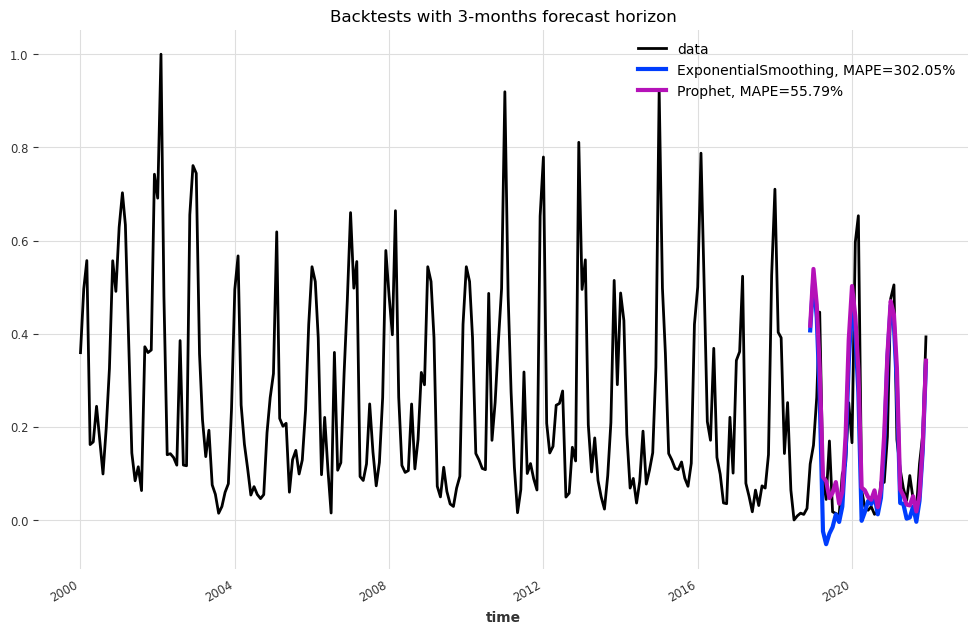

In [45]:
#--------------------------------------------------#
# Forecast the last three years of the time series # 
# using backtesting process                        #
#--------------------------------------------------#
models_str = ['ExponentialSmoothing', 'Prophet']
ts_scaled.plot(label='data')
for i, m in enumerate(models_str):
    err = mape(backtests[i], ts_scaled)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()

Backtesting forecasting models — here we simulate making forecasts with a 3 months horizon, every month starting in January 2019 (so the first forecast value is for April 2019).

### <div class="alert-danger">  Q3) Try to optimize these models using one of the different techniques listed above.  </div>  